In [44]:
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

rows_used=314 #  this is the number of images i will be using eventually i will be using even more images but for now
path="/content/drive/MyDrive/ALL programs/Face Detection Manga Characters/Data/"

In [45]:
df=pd.read_csv("/content/drive/MyDrive/ALL programs/Face Detection Manga Characters/OPDATAupload.csv")
df.drop(df.index[rows_used:], axis=0, inplace=True)
df #all NaN values are places where the character is not found and can be replaced with 0

,chap,page,luffy,zoro,nami,usopp,sanji,chopper,robin,franky
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
309,13,19,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
310,13,20,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
311,13,21,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
312,14,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
chap_page=df[["chap","page"]].copy()
df=df[["luffy","zoro","nami"]] #selecting only 1st 3 character as this is a sample and evntually I will do with everyone

In [47]:
df=df.drop(df.index[314:], axis=0)
label=df.fillna(0).values 

In [48]:
chap_page["chap"]=chap_page["chap"].astype(str)
chap_page["page"]=chap_page["page"].astype(str)
chap_page["chap_page"]=chap_page["chap"]+"-"+chap_page["page"]
chap_page=chap_page["chap_page"]

In [49]:
path="/content/drive/MyDrive/ALL programs/Face Detection Manga Characters/Data/"
chap_page=path+chap_page+".jpg"

In [50]:
blankimagelist=[str(i)+"-1.jpg" for i in list(range(1,15))] #these images are just black and has nothing in them

In [53]:
n=np.zeros((len(chap_page)-len(blankimagelist),300,300,3))
labels=[]
j=0
for i in tqdm(range(len(chap_page))):
  if chap_page[i][73:] not in blankimagelist:
    img = Image.open(chap_page[i])
    img=tf.image.resize(
      img,
      (300,300)
    )
    labels.append(label[i])
    n[j]=img
    j=j+1
labels=np.array(labels)
labels.shape

100%|██████████| 314/314 [00:07<00:00, 43.14it/s]


(300, 3)

Label: [1. 0. 0.]


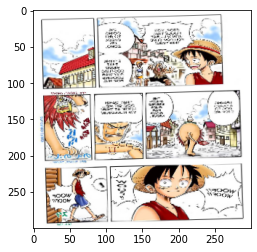

Label: [1. 0. 0.]


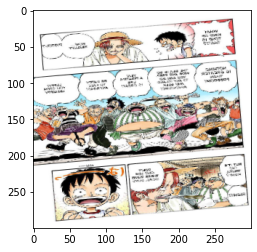

Label: [1. 0. 0.]


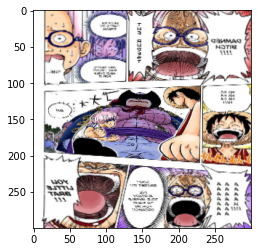

Label: [1. 0. 0.]


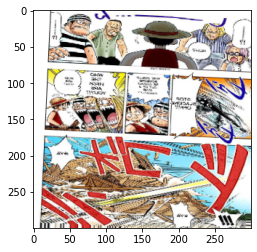

Label: [0. 0. 0.]


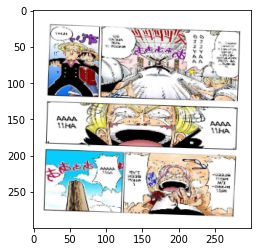

In [55]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=5,
    width_shift_range=0,
    height_shift_range=0,
    brightness_range=None,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    rescale=1./255
)

train_generator=train_datagen.flow(
    n,
    y=labels,
    batch_size=32,
    shuffle=True,
    sample_weight=None,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    ignore_class_split=False
)

for _ in range(5):
    img, label = train_generator.next()
    print("Label:",label[5])   
    plt.imshow(img[5])
    plt.show()


In [56]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid') # 3 different classes that can occur simultaneously
])

model.compile(
    optimizer="Adam",
    loss="BinaryCrossentropy",
    metrics=["accuracy"]
)


In [57]:
def scheduler(epoch, lr):
  lr=0.0010
  #if epoch < 2:
  return lr
  #else:
  #  return lr * tf.math.exp(-0.7)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(
    train_generator,
    epochs=25,
    batch_size=32
)

Epoch 1/25
10/10 [==============================] - 11s 607ms/step - loss: 1.9861 - accuracy: 0.5300
Epoch 2/25
10/10 [==============================] - 6s 544ms/step - loss: 1.1482 - accuracy: 0.6033
Epoch 3/25
10/10 [==============================] - 7s 674ms/step - loss: 0.7386 - accuracy: 0.6367
Epoch 4/25
10/10 [==============================] - 6s 589ms/step - loss: 0.4525 - accuracy: 0.7433
Epoch 5/25
10/10 [==============================] - 6s 598ms/step - loss: 0.2394 - accuracy: 0.7700
Epoch 6/25
10/10 [==============================] - 7s 692ms/step - loss: 0.2296 - accuracy: 0.7867
Epoch 7/25
10/10 [==============================] - 5s 569ms/step - loss: 0.1683 - accuracy: 0.7800
Epoch 8/25
10/10 [==============================] - 7s 675ms/step - loss: 0.0974 - accuracy: 0.7500
Epoch 9/25
10/10 [==============================] - 6s 546ms/step - loss: 0.1079 - accuracy: 0.7533
Epoch 10/25
10/10 [==============================] - 6s 637ms/step - loss: 0.0696 - accuracy: 0.790

1/1 [==============================] - 0s 118ms/step
Label: [1. 0. 1.]  Prediction: [[1 0 1]] [[9.9911231e-01 4.6242832e-05 9.8497772e-01]]


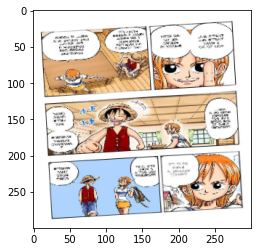

1/1 [==============================] - 0s 28ms/step
Label: [0. 1. 1.]  Prediction: [[0 0 0]] [[1.8877301e-07 4.5817476e-03 8.2177180e-04]]


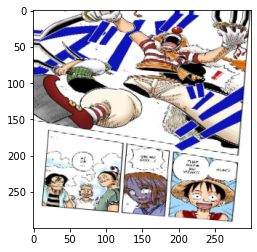

1/1 [==============================] - 0s 23ms/step
Label: [1. 0. 0.]  Prediction: [[1 0 0]] [[0.9945068  0.01238999 0.00165196]]


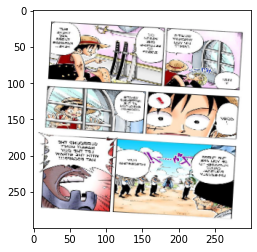

1/1 [==============================] - 0s 23ms/step
Label: [0. 0. 0.]  Prediction: [[0 0 0]] [[1.1347699e-03 5.7295642e-07 4.0841860e-07]]


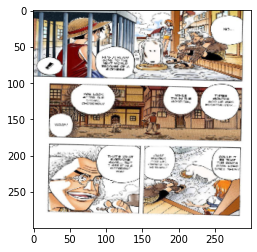

1/1 [==============================] - 0s 19ms/step
Label: [1. 0. 0.]  Prediction: [[1 0 0]] [[9.8256612e-01 1.0200668e-03 5.1803677e-04]]


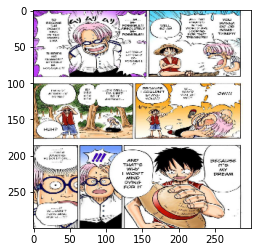

In [58]:
for _ in range(5):
    img, label = train_generator.next()
    X= np.expand_dims(img[5], axis=0)
    pred=model.predict(X)
    print("Label:",label[5]," Prediction:",np.where(pred>0.5,1,0),pred)   #  (1,256,256,3)
    plt.imshow(img[5])
    plt.show()

## Sample Test

Saving 8-20.jpg to 8-20.jpg


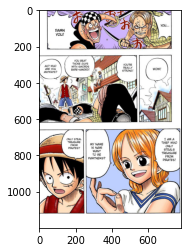

1/1 [==============================] - 0s 23ms/step
This Image Contains : 
Luffy
Nami


In [66]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path)
  plt.imshow(img)
  plt.show()

  img=load_img(path, target_size=(300, 300))
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  
  classes = model.predict(x)
  classes=np.where(classes>0.5,1,0)


  print("This Image Contains : ")
  if classes[0][0]==1:
    print("Luffy")
  if classes[0][1]==1:
    print("Zoro")
  if classes[0][2]==1:
    print("Nami")
  if classes[0][0]==0 and classes[0][1]==0 and classes[0][2]==0:
    print("None of them")